In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import json
import os
import sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Add modules to path
sys.path.append('modules')

# Import our custom utilities
from data_utils import load_processed_data, create_data_loaders
from model_utils import CNNBaseline, train_model, evaluate_model

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")



In [2]:
# Load preprocessed data
train_df, val_df, test_df, label_encoder, config = load_processed_data()
print(f"Data loaded: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test samples")

# Load text embeddings from Phase 4
try:
    tfidf_embeddings = np.load('embeddings/tfidf_embeddings.npy')
    print(f"TF-IDF embeddings loaded: {tfidf_embeddings.shape}")
    
    # Try to load BERT embeddings if available
    try:
        bert_embeddings = np.load('embeddings/bert_embeddings.npy')
        print(f"BERT embeddings loaded: {bert_embeddings.shape}")
    except FileNotFoundError:
        bert_embeddings = None
        print("BERT embeddings not found, using TF-IDF only")
        
except FileNotFoundError:
    print("Text embeddings not found.")
    raise



Data loaded: 1378 train, 460 val, 460 test samples
TF-IDF embeddings loaded: (2298, 128)
BERT embeddings loaded: (2298, 384)


In [4]:



# Load CNN baseline results
cnn_model = {}

cnn_model['best_model'] = 'resnet50_baseline_best.pth'
cnn_model['best_accuracy'] = 0.5543

print(f"\n🎯 Ready for multimodal fusion!")


🎯 Ready for multimodal fusion!


In [6]:
# Multimodal Fusion Model
class MultimodalFusionModel(nn.Module):
    def __init__(self, cnn_model, text_embedding_dim, num_classes, fusion_type='concat'):
        super(MultimodalFusionModel, self).__init__()
        
        self.cnn_model = cnn_model
        self.fusion_type = fusion_type
        self.num_classes = num_classes
        
        # Freeze CNN backbone
        for param in self.cnn_model.parameters():
            param.requires_grad = False
        
        # Get CNN feature dimension
        cnn_feature_dim = self.cnn_model.backbone.fc.in_features
        
        if fusion_type == 'concat':
            # Simple concatenation fusion
            fusion_input_dim = cnn_feature_dim + text_embedding_dim
            self.fusion_layer = nn.Sequential(
                nn.Linear(fusion_input_dim, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, num_classes)
            )
    
    def forward(self, images, text_embeddings):
        # Get CNN features
        cnn_features = self.cnn_model.backbone.avgpool(
            self.cnn_model.backbone.layer4(
                self.cnn_model.backbone.layer3(
                    self.cnn_model.backbone.layer2(
                        self.cnn_model.backbone.layer1(
                            self.cnn_model.backbone.maxpool(
                                self.cnn_model.backbone.relu(
                                    self.cnn_model.backbone.bn1(
                                        self.cnn_model.backbone.conv1(images)
                                    )
                                )
                            )
                        )
                    )
                )
            )
        ).flatten(1)
        
        # Concatenate features
        fused_features = torch.cat([cnn_features, text_embeddings], dim=1)
        output = self.fusion_layer(fused_features)
        
        return output

print("Multimodal fusion model defined!")


Multimodal fusion model defined!


In [7]:
# Create Multimodal Dataset
class MultimodalDataset(torch.utils.data.Dataset):
    def __init__(self, df, text_embeddings, image_dirs, transform=None):
        self.df = df.reset_index(drop=True)
        self.text_embeddings = text_embeddings
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row['img_id']
        
        # Load image
        img = None
        for part, dir_path in self.image_dirs.items():
            full_path = os.path.join('archive', dir_path, img_id)
            if os.path.exists(full_path):
                try:
                    from PIL import Image
                    img = Image.open(full_path).convert('RGB')
                    break
                except Exception as e:
                    continue
        
        if img is None:
            img = Image.new('RGB', (224, 224), color='black')
        
        if self.transform:
            img = self.transform(img)
        
        # Get text embedding
        text_embedding = torch.FloatTensor(self.text_embeddings[idx])
        
        # Get target
        target = row['diagnostic']
        
        return img, text_embedding, target

# Create datasets
IMAGE_DIRS = {
    'part1': 'imgs_part_1/imgs_part_1',
    'part2': 'imgs_part_2/imgs_part_2', 
    'part3': 'imgs_part_3/imgs_part_3'
}

# Get transforms
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = MultimodalDataset(train_df, tfidf_embeddings[:len(train_df)], IMAGE_DIRS, train_transform)
val_dataset = MultimodalDataset(val_df, tfidf_embeddings[len(train_df):len(train_df)+len(val_df)], IMAGE_DIRS, val_transform)
test_dataset = MultimodalDataset(test_df, tfidf_embeddings[len(train_df)+len(val_df):], IMAGE_DIRS, val_transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Multimodal datasets created:")
print(f"  - Train: {len(train_dataset)} samples")
print(f"  - Val: {len(val_dataset)} samples")
print(f"  - Test: {len(test_dataset)} samples")
print(f"  - Text embedding dim: {tfidf_embeddings.shape[1]}")


Multimodal datasets created:
  - Train: 1378 samples
  - Val: 460 samples
  - Test: 460 samples
  - Text embedding dim: 128


In [9]:
torch.__version__

'2.8.0+cu129'

In [10]:
# Create and Train Multimodal Models
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create CNN backbone (use the best model from Phase 3)
cnn_backbone = CNNBaseline(
    num_classes=config['num_classes'],
    model_name='resnet34',  # Use a smaller model for faster training
    pretrained=True
)

# Create multimodal model
multimodal_model = MultimodalFusionModel(
    cnn_model=cnn_backbone,
    text_embedding_dim=tfidf_embeddings.shape[1],
    num_classes=config['num_classes'],
    fusion_type='concat'
)

print(f"Multimodal model created:")
print(f"  - Parameters: {sum(p.numel() for p in multimodal_model.parameters()):,}")
print(f"  - Trainable parameters: {sum(p.numel() for p in multimodal_model.parameters() if p.requires_grad):,}")

# Move model to device
multimodal_model = multimodal_model.to(device)

# Training function for multimodal model
def train_multimodal_model(model, train_loader, val_loader, num_epochs=30, learning_rate=0.001, device='cuda'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    
    print(f"Starting multimodal training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, text_embeddings, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]'):
            images = images.to(device)
            text_embeddings = text_embeddings.to(device)
            
            # Encode targets if they are strings
            if label_encoder is not None:
                targets = torch.tensor(label_encoder.transform(targets), dtype=torch.long)
            else:
                targets = torch.tensor(targets, dtype=torch.long)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(images, text_embeddings)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, text_embeddings, targets in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]'):
                images = images.to(device)
                text_embeddings = text_embeddings.to(device)
                
                if label_encoder is not None:
                    targets = torch.tensor(label_encoder.transform(targets), dtype=torch.long)
                else:
                    targets = torch.tensor(targets, dtype=torch.long)
                targets = targets.to(device)
                
                outputs = model(images, text_embeddings)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
        
        # Calculate metrics
        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler.step()
        
        # Print epoch results
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'models/multimodal_best.pth')
            print(f'New best model saved! Val Acc: {val_acc:.2f}%')
    
    return history

# Train the multimodal model
print("Starting multimodal model training...")
multimodal_history = train_multimodal_model(
    model=multimodal_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=30,
    learning_rate=0.001,
    device=device
)

print("Multimodal model training completed!")


Using device: cuda
Multimodal model created:
  - Parameters: 21,748,812
  - Trainable parameters: 461,062
Starting multimodal model training...
Starting multimodal training for 30 epochs...


Epoch 1/30 [Val]: 100%|██████████| 15/15 [00:24<00:00,  1.62s/it]


Epoch 1/30:
  Train Loss: 1.4770, Train Acc: 41.07%
  Val Loss: 1.2998, Val Acc: 56.30%
New best model saved! Val Acc: 56.30%


Epoch 2/30 [Val]: 100%|██████████| 15/15 [00:18<00:00,  1.25s/it]


Epoch 2/30:
  Train Loss: 1.3455, Train Acc: 49.06%
  Val Loss: 1.3388, Val Acc: 48.26%


Epoch 3/30 [Val]: 100%|██████████| 15/15 [00:19<00:00,  1.32s/it]


Epoch 3/30:
  Train Loss: 1.2296, Train Acc: 52.25%
  Val Loss: 1.1571, Val Acc: 54.57%


Epoch 4/30 [Val]: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]


Epoch 4/30:
  Train Loss: 1.2434, Train Acc: 53.70%
  Val Loss: 1.3071, Val Acc: 46.52%


Epoch 5/30 [Val]: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


Epoch 5/30:
  Train Loss: 1.2099, Train Acc: 52.39%
  Val Loss: 1.1598, Val Acc: 54.13%


Epoch 6/30 [Val]: 100%|██████████| 15/15 [00:21<00:00,  1.47s/it]


Epoch 6/30:
  Train Loss: 1.1866, Train Acc: 54.28%
  Val Loss: 1.2995, Val Acc: 47.39%


Epoch 7/30 [Val]: 100%|██████████| 15/15 [00:22<00:00,  1.47s/it]


Epoch 7/30:
  Train Loss: 1.1469, Train Acc: 56.31%
  Val Loss: 1.2482, Val Acc: 47.83%


Epoch 8/30 [Val]: 100%|██████████| 15/15 [00:22<00:00,  1.51s/it]


Epoch 8/30:
  Train Loss: 1.1713, Train Acc: 56.02%
  Val Loss: 1.1970, Val Acc: 50.65%


Epoch 9/30 [Val]: 100%|██████████| 15/15 [00:23<00:00,  1.60s/it]


Epoch 9/30:
  Train Loss: 1.1497, Train Acc: 56.89%
  Val Loss: 1.1800, Val Acc: 51.52%


Epoch 10/30 [Val]: 100%|██████████| 15/15 [00:24<00:00,  1.63s/it]


Epoch 10/30:
  Train Loss: 1.1434, Train Acc: 56.75%
  Val Loss: 1.2469, Val Acc: 48.70%


Epoch 11/30 [Val]: 100%|██████████| 15/15 [00:27<00:00,  1.82s/it]


Epoch 11/30:
  Train Loss: 1.1124, Train Acc: 57.76%
  Val Loss: 1.2691, Val Acc: 50.43%


Epoch 12/30 [Val]: 100%|██████████| 15/15 [00:23<00:00,  1.56s/it]


Epoch 12/30:
  Train Loss: 1.0862, Train Acc: 58.35%
  Val Loss: 1.1462, Val Acc: 54.78%


Epoch 13/30 [Val]: 100%|██████████| 15/15 [00:23<00:00,  1.58s/it]


Epoch 13/30:
  Train Loss: 1.0924, Train Acc: 58.85%
  Val Loss: 1.1293, Val Acc: 53.91%


Epoch 14/30 [Val]: 100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Epoch 14/30:
  Train Loss: 1.0658, Train Acc: 59.72%
  Val Loss: 1.1294, Val Acc: 55.87%


Epoch 15/30 [Val]: 100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Epoch 15/30:
  Train Loss: 1.0527, Train Acc: 59.43%
  Val Loss: 1.1449, Val Acc: 53.26%


Epoch 16/30 [Val]: 100%|██████████| 15/15 [00:24<00:00,  1.62s/it]


Epoch 16/30:
  Train Loss: 1.0361, Train Acc: 60.81%
  Val Loss: 1.1784, Val Acc: 52.61%


Epoch 17/30 [Val]: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]


Epoch 17/30:
  Train Loss: 1.0127, Train Acc: 59.94%
  Val Loss: 1.1218, Val Acc: 54.78%


Epoch 18/30 [Val]: 100%|██████████| 15/15 [00:24<00:00,  1.65s/it]


Epoch 18/30:
  Train Loss: 1.0108, Train Acc: 61.10%
  Val Loss: 1.1731, Val Acc: 51.96%


Epoch 19/30 [Val]: 100%|██████████| 15/15 [00:25<00:00,  1.69s/it]


Epoch 19/30:
  Train Loss: 0.9780, Train Acc: 63.50%
  Val Loss: 1.1909, Val Acc: 53.48%


Epoch 20/30 [Val]: 100%|██████████| 15/15 [00:24<00:00,  1.63s/it]


Epoch 20/30:
  Train Loss: 1.0075, Train Acc: 61.90%
  Val Loss: 1.0783, Val Acc: 56.96%
New best model saved! Val Acc: 56.96%


Epoch 21/30 [Val]: 100%|██████████| 15/15 [00:24<00:00,  1.66s/it]


Epoch 21/30:
  Train Loss: 1.0201, Train Acc: 60.96%
  Val Loss: 1.0585, Val Acc: 59.78%
New best model saved! Val Acc: 59.78%


Epoch 22/30 [Val]: 100%|██████████| 15/15 [00:24<00:00,  1.65s/it]


Epoch 22/30:
  Train Loss: 1.0411, Train Acc: 57.47%
  Val Loss: 1.0783, Val Acc: 57.17%


Epoch 23/30 [Val]: 100%|██████████| 15/15 [00:24<00:00,  1.66s/it]


Epoch 23/30:
  Train Loss: 0.9894, Train Acc: 61.18%
  Val Loss: 1.1096, Val Acc: 57.61%


Epoch 24/30 [Val]: 100%|██████████| 15/15 [00:23<00:00,  1.58s/it]


Epoch 24/30:
  Train Loss: 0.9754, Train Acc: 62.26%
  Val Loss: 1.1096, Val Acc: 56.09%


Epoch 25/30 [Val]: 100%|██████████| 15/15 [00:23<00:00,  1.55s/it]


Epoch 25/30:
  Train Loss: 1.0302, Train Acc: 61.61%
  Val Loss: 1.1052, Val Acc: 55.00%


Epoch 26/30 [Val]: 100%|██████████| 15/15 [00:25<00:00,  1.69s/it]


Epoch 26/30:
  Train Loss: 0.9682, Train Acc: 63.13%
  Val Loss: 1.1038, Val Acc: 55.00%


Epoch 27/30 [Val]: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]


Epoch 27/30:
  Train Loss: 0.9491, Train Acc: 62.55%
  Val Loss: 1.1394, Val Acc: 55.00%


Epoch 28/30 [Val]: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]


Epoch 28/30:
  Train Loss: 0.9766, Train Acc: 62.55%
  Val Loss: 1.1112, Val Acc: 54.57%


Epoch 29/30 [Val]: 100%|██████████| 15/15 [00:29<00:00,  1.99s/it]


Epoch 29/30:
  Train Loss: 0.9759, Train Acc: 61.61%
  Val Loss: 1.1147, Val Acc: 55.65%


Epoch 30/30 [Val]: 100%|██████████| 15/15 [00:22<00:00,  1.48s/it]

Epoch 30/30:
  Train Loss: 0.9864, Train Acc: 63.57%
  Val Loss: 1.1171, Val Acc: 55.43%
Multimodal model training completed!


In [11]:
# Evaluate Multimodal Model
# Load best model
multimodal_model.load_state_dict(torch.load('models/multimodal_best.pth', map_location=device))

# Evaluate on test set
multimodal_model.eval()
all_predictions = []
all_targets = []
all_probabilities = []


with torch.no_grad():
    for images, text_embeddings, targets in tqdm(test_loader, desc='Testing'):
        images = images.to(device)
        text_embeddings = text_embeddings.to(device)
        
        # Encode targets
        if label_encoder is not None:
            targets = torch.tensor(label_encoder.transform(targets), dtype=torch.long)
        else:
            targets = torch.tensor(targets, dtype=torch.long)
        targets = targets.to(device)
        
        outputs = multimodal_model(images, text_embeddings)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

# Calculate metrics
multimodal_accuracy = accuracy_score(all_targets, all_predictions)

print(f"Multimodal Model Results:")
print(f"  - Test Accuracy: {multimodal_accuracy:.4f} ({multimodal_accuracy*100:.2f}%)")


Testing: 100%|██████████| 15/15 [00:22<00:00,  1.51s/it]

Multimodal Model Results:
  - Test Accuracy: 0.5957 (59.57%)


In [13]:

# Compare with CNN baseline
cnn_accuracy = cnn_model['best_accuracy']
improvement = multimodal_accuracy - cnn_accuracy

print(f"Performance Comparison:")
print(f"  - CNN Baseline: {cnn_accuracy:.4f} ({cnn_accuracy*100:.2f}%)")
print(f"  - Multimodal Model: {multimodal_accuracy:.4f} ({multimodal_accuracy*100:.2f}%)")
print(f"  - Improvement: {improvement:.4f} ({improvement*100:.2f}%)")

if improvement > 0:
    print("Multimodal model outperforms CNN baseline!")
else:
    print("Multimodal model needs further optimization")

# Classification report
print(f"Detailed Classification Report:")
report = classification_report(all_targets, all_predictions, 
                            target_names=config['class_names'], digits=4)
print(report)


Performance Comparison:
  - CNN Baseline: 0.5543 (55.43%)
  - Multimodal Model: 0.5957 (59.57%)
  - Improvement: 0.0414 (4.14%)
Multimodal model outperforms CNN baseline!
Detailed Classification Report:
              precision    recall  f1-score   support

         ACK     0.5960    0.6164    0.6061       146
         BCC     0.6274    0.7870    0.6982       169
         MEL     0.0000    0.0000    0.0000        10
         NEV     0.5139    0.7551    0.6116        49
         SCC     0.0000    0.0000    0.0000        39
         SEK     0.5600    0.2979    0.3889        47

    accuracy                         0.5957       460
   macro avg     0.3829    0.4094    0.3841       460
weighted avg     0.5316    0.5957    0.5537       460



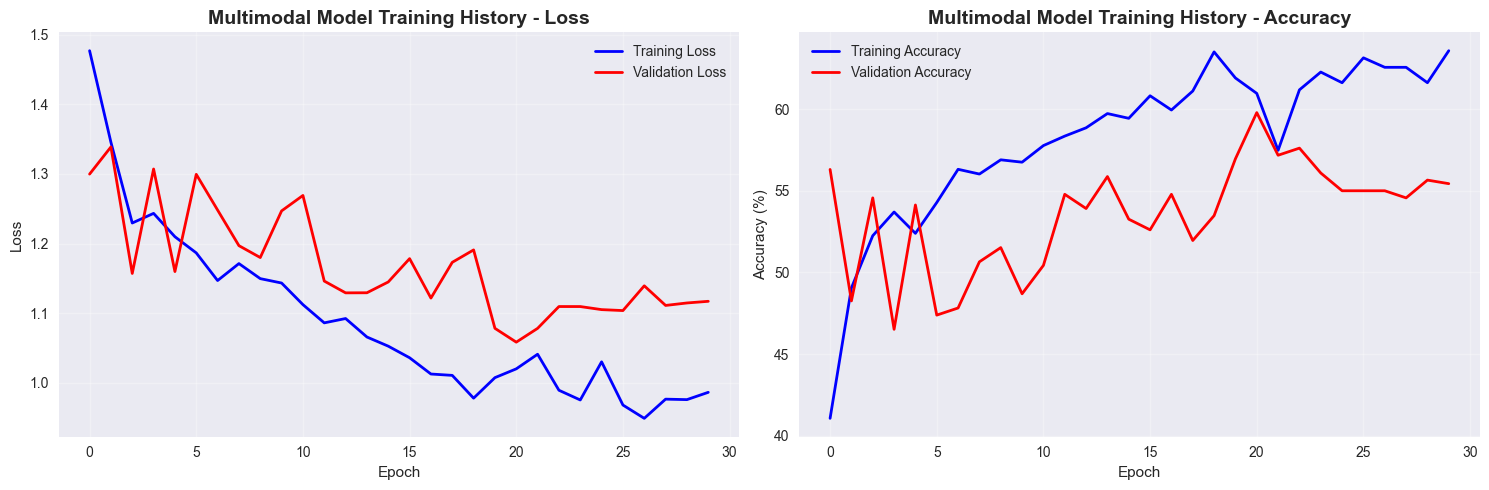

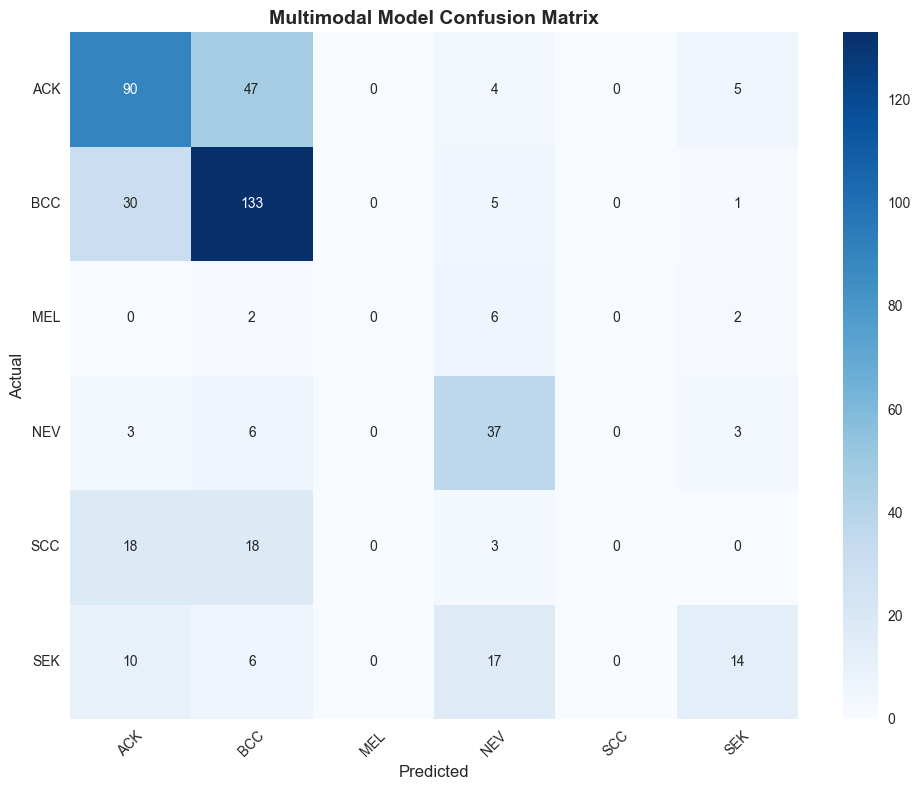

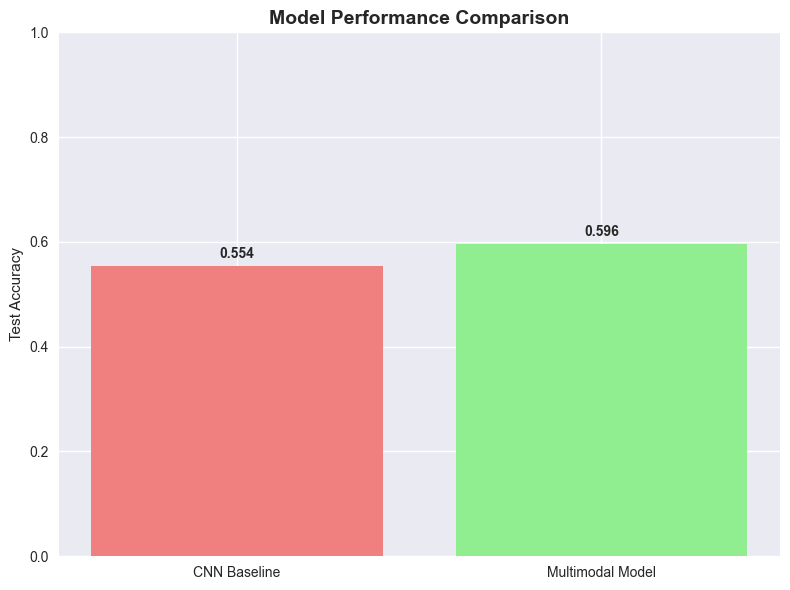

In [14]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(multimodal_history['train_loss'], label='Training Loss', color='blue', linewidth=2)
ax1.plot(multimodal_history['val_loss'], label='Validation Loss', color='red', linewidth=2)
ax1.set_title('Multimodal Model Training History - Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(multimodal_history['train_acc'], label='Training Accuracy', color='blue', linewidth=2)
ax2.plot(multimodal_history['val_acc'], label='Validation Accuracy', color='red', linewidth=2)
ax2.set_title('Multimodal Model Training History - Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_targets, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=config['class_names'], yticklabels=config['class_names'])
plt.title('Multimodal Model Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Performance comparison chart
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
models = ['CNN Baseline', 'Multimodal Model']
accuracies = [cnn_accuracy, multimodal_accuracy]
colors = ['lightcoral', 'lightgreen']

bars = ax.bar(models, accuracies, color=colors)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Test Accuracy')
ax.set_ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [18]:
# Create results summary
multimodal_results = {
    'model_type': 'multimodal_fusion',
    'fusion_strategy': 'concatenation',
    'text_embedding_type': 'tfidf',
    'cnn_backbone': 'resnet34',
    'test_accuracy': float(multimodal_accuracy),
    'cnn_baseline_accuracy': float(cnn_accuracy),
    'improvement': float(improvement),
    'training_history': multimodal_history,
    'predictions': [int(p) for p in np.array(all_predictions).flatten()],
    'targets': [int(t) for t in np.array(all_targets).flatten()],
    'probabilities': [np.array(prob) for prob in all_probabilities]
}

# Save results
with open('models/multimodal_results.json', 'w') as f:
    # Convert numpy arrays to lists for JSON serialization
    json_results = {
        'model_type': multimodal_results['model_type'],
        'fusion_strategy': multimodal_results['fusion_strategy'],
        'text_embedding_type': multimodal_results['text_embedding_type'],
        'cnn_backbone': multimodal_results['cnn_backbone'],
        'test_accuracy': multimodal_results['test_accuracy'],
        'cnn_baseline_accuracy': multimodal_results['cnn_baseline_accuracy'],
        'improvement': multimodal_results['improvement'],
        'training_history': multimodal_results['training_history'],
        'predictions': multimodal_results['predictions'],
        'targets': multimodal_results['targets'],
        'probabilities': [prob.tolist() for prob in multimodal_results['probabilities']]
    }
    json.dump(json_results, f, indent=4)
